In [92]:
%pylab inline
from scipy import optimize
from IPython.display import display, Math, Latex
import emcee
import matplotlib.gridspec as gridspec
#import corner
from scipy import stats 

Populating the interactive namespace from numpy and matplotlib


In [93]:
#mass units
M = (10.0**10)/0.7
#vol of illustris run
vol = (75.0/(0.7))**3
print(75./0.7)

# Gives the x,y of the histogram for logmasses from the given array of mass
def histog( mf, nbins ):
    hist, bin_edges = np.histogram(mf, bins = nbins)
    # Obtains the center point for each bin
    xcenter = (bin_edges[:-1] + bin_edges[1:])/2
    return np.array(xcenter), np.array(hist/vol)

# Truncates float to n decimal parts
def truncate(d,n):
    before_dec, after_dec = str(d).split('.')
    d = float('.'.join((before_dec, after_dec[0:n-1])))
    return d

# Schechter function
def Schechter(m,phi_s,alpha,m_s):
    MHI = 10.**m
    M_s = 10.**m_s
    return np.log(10.)*phi_s*((MHI/M_s)**(alpha+1))*numpy.exp(-MHI/M_s)

# loads the file with halo masses and makes the quartiles
# file formated env,mass
# j defines if we treat gass or dm j = 0,1
# j = 0 -> gas
# j = 1 -> dm
# j = 2 -> stars and dust
# j = 3 -> black holes
# j = 4 -> central black hole
# minMass minimum mass allowed to have into account a halo
def loadHaloes(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j])> minMass)]
    mass = M*mtable[j][where(M*mtable[j]> minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1
    global q2
    global q3
    global q4
    global q5
    q5 = M*mtable[j][where(M*mtable[j]> minMass)]

    
    q = np.percentile(lsigma,25)
    # Keeps first quartile
    q1 = mass[where(lsigma <= q)]
    # Removes fist quartile from lsigma
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Second quartile
    q = np.percentile(lsigma,33.333333)
    q2 = mass[where(lsigma <= q)]
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Third and Fourth quartile
    q = np.percentile(lsigma,50)
    q3 = mass[where(lsigma <= q)]
    q4 = mass[where(lsigma >= q)]
    
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))

# Loads the file with environment classification T-Web
# file formated env,massgas,masdm
# j defines if we treat gass or dm j = 0,1
# minMass minimum mass allowed to have into account a halo
def loadTweb(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j]) > minMass)]
    mass = M*mtable[j][where(M*mtable[j] > minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1 
    global q2 
    global q3 
    global q4 
    global q5 
    q1 = mass[np.where(lsigma == 3)]
    q2 = mass[np.where(lsigma == 2)]
    q3 = mass[np.where(lsigma == 1)]
    q4 = mass[np.where(lsigma == 0)]
    q5 = mass
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))
    
def SchtrGraph2(bins,filename,title, boolean):
    # Graphics of the mass function for each quartile
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)

    
    # Plots Total mass function
    '''
    fig, axes = plt.subplots( nrows=2, ncols=1, figsize=(15,20) )
    gs = gridspec.GridSpec(2,1)
    ax0 = plt.subplot(gs[0, 0])
    ax = plt.subplot(gs[1,0])
    tmp = histog(log10(q5),bins+5)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    ax0.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol)), fmt='o', ecolor = 'b',
                        c = 'g', markersize=7,elinewidth=1.5)
    '''
    
    # Callable lists
    qs = [q1,q2,q3,q4]
    indx = ['1st quartile','2nd quartile','3rd quartile','4th quartile']
    cs = ['b','g','r','y']
    fmts = ['o','>','<','s']
    alph = []
    dalph = []
    ms = []
    dms = []
    minx = 40
    maxx = -1
    miny = 100
    maxy = -100
    # Chooses normalization factor as first phi_s
    tmp = histog(log10(q1),15)
    #rint(tmp)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    phi = 1
    if ( boolean ):
        fiiit,sampler = fitMCMC(tmp)
        #print(fiiit)
        ft = fiiit.T[0]
        errors = fiiit.T[1:]
        phi = ft[0]
    ind = 0
    for q,i,co,fm in zip(qs,indx,cs,fmts):
        # Histo for first quartile
        tmp = histog(log10(q),bins)
        tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
        #print tmp
        if ( boolean ):
            logm = linspace(min(tmp[0])-0.3,max(tmp[0])+0.1, 200)
            fiiit,sampler = fitMCMC(tmp)
            #print(fiiit)
            ft = fiiit.T[0]
            errors = fiiit.T[1:].T
            print("......................................................")
            print(ft[0],errors[0])
            print(ft[1],errors[1])
            print(ft[2],errors[2])
            ax.errorbar( tmp[0], log10(tmp[1]*(phi/ft[0]))-ind,  1./(sqrt(tmp[1]*vol)), fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        else: 
            ax.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol))-ind, fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        # Decimals to show
        if ( boolean ):
            m = 5
            ax.plot(logm, log10(Schechter(logm,ft[0],ft[1],ft[2])*(phi/ft[0])) -ind,co, 
                 label = r"$\alpha$ = " + str(truncate(ft[1],m))+"\n"
                 + r"$m_\ast$ = " + str(truncate(ft[2],m))+"\n"  )
            alph.append(ft[1])
            dalph.append(errors[1])
            ms.append(ft[2])
            dms.append(errors[2])
            #ax.bar( tmp[0] , log10(tmp[1]), width = tmp[0][1]-tmp[0][2], alpha = 0.4, align = 'center' )
            ax.legend(prop={'size':13})
        #savetxt(name + "q2.csv",(array([tmp[0], tmp[1], sqrt(vol*tmp[1])/(vol*tmp[1])]).T), delimiter = ',')
        #ax.set_title(i, fontsize = 18)
        ax.set_ylabel('$Log_{10}(n)$', fontsize = 20)
        ax.set_xlabel('$Log_{10}(M/M_{\odot})$', fontsize = 20)
        minx = min([minx,min(tmp[0])])
        maxx = max([maxx,max(tmp[0])])
        if ( boolean ):
            miny = min([miny,min(log10(tmp[1]*(phi/ft[0])))-ind])
            maxy = max([maxy,max(log10(tmp[1]*(phi/ft[0])))-ind])
        else:
            miny = min([miny,min(log10(tmp[1]))-ind])
            maxy = max([maxy,max(log10(tmp[1]))-ind])
        ################################################################
        ind += 0.5
    ax.set_title(title,fontsize = 20)
    tmp = histog(log10(q5),bins)
    ax.set_xlim(minx-0.3,maxx+0.3)
    if ( boolean ):
        ax.set_xlim(minx-0.3,maxx+1.5)
    ax.set_ylim(miny-0.3,maxy+0.3)
    #ax.set_ylim(-6.,0.)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    savefig(filename)
    return array(alph),array(dalph).T,array(ms),array(dms).T

    
def graph(x,dx,d,name,title,filename):
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    q = [1,2,3,4]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    ax.errorbar( q, x, yerr = dx, fmt='o', ecolor = 'r', c = 'b', markersize=7,elinewidth=1.5)
    ax.set_xlim(0.5,4.5)
    ax.set_ylim(min(x)-d,max(x)+d)
    ax.set_ylabel(name, fontsize = 30)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel(r'$Environment$', fontsize = 30)
    ax.set_title(title, fontsize = 30)
    savefig(filename)


107.14285714285715


In [94]:
# Defines functions for emcee
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    norm,alpha,m = p
    # We're using only uniform priors, and only eps has a lower bound
    if norm > 0 and   8 < m < 20 and -3 < alpha < 1:
        return 0
    return -np.inf

# Defines the likelihood
def lnlike(p, x, y, yerr):
    model = SchechterMC(x,p)
    # the likelihood is sum of the lot of normal distributions
    denom = power(yerr,2.)
    lp = -0.5*sum(power((y - model),2.)/denom + log(denom)) 
    return lp

# The probability
def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    if not isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y, yerr)

# MCMC fit
p0 = [0.003, -1., 10.]
def fitSci(tmp,yerr,p):
    return optimize.curve_fit(Schechter,tmp[0] ,tmp[1],p0=[0,-2.0,12], sigma = np.sqrt(tmp[1]/vol),
    #bounds = (np.array([0,-np.inf,8.]),np.array([np.inf,np.inf,20.])),method = 'trf',
    maxfev = 100000)


# Schechter function
def SchechterMC(m,params):
    MHI = 10.**m
    M_s = 10.**params[2]
    return np.log(10.)*params[0]*((MHI/M_s)**(params[1]+1))*numpy.exp(-MHI/M_s)

# Gets the error taking into account the confidence interval
# Arr -> the array
# center -> central value to calculate the interval
# perc -> percent of data within the interval
def getErr(arr, center, perc):
    #conf_int  = stats.norm.interval(perc, loc = center, scale = 1 )
    conf_int  = stats.norm.interval(perc, loc = center, scale = np.std(arr))
    return conf_int

# Uses MCMC emcee to improve the SchechterMC fit and error estimation
# return the best fit values and their respective errors within confidence interval given by perc = (0.68,0.95)
# temp -> data to fit
# Nsteps -> steps for MCMC
# Nwalkers -> number of MCMC walkers
# suggestion: fitMCMC(temp,0.68,1000,50)
def fitMCMC(tmp):
    Nsteps = 1000
    Nwalker = 50
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    # The error in y assuming poisson dist
    yerr = sqrt(tmp[1]/vol)
    # Uses scipy fit as initial guess
    p00 = [0.003,-1.,10.]
    ft,errors = fitSci(tmp,yerr,p00)
    #print ft
    # Creates walkers around initial guess
    Ndim = 3
    walkers = [ft+[1.e-7*random.randn(),1.e-4*random.randn(),1.e-3*random.randn()] for i in range(Nwalker)]
    # Initialises sampler
    sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,args=(tmp[0],tmp[1],yerr))
    pos,prob,state = sampler.run_mcmc(walkers, 500)
    sampler.reset()
    #res=plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
    #axhline(ft[1], color='blue')
    # Runs the walks
    pos,prob,state = sampler.run_mcmc(pos, Nsteps)
    # fit and Errors in format (fit,upper,lower)
    samples = sampler.chain[:, 50:, :].reshape((-1, Ndim))
    #corner.corner(samples, labels=['normV','alpha','m*'], 
     #           truths=[ft[0], ft[1], ft[2]])
    #print shape(samples)
    fit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    return array(list(fit)),samples

# GAS NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 144832
36208 36208 36208 36208 144832
......................................................
0.00195123868529 [  3.74868149e-05   3.76214980e-05]
-1.04839192744 [ 0.00590874  0.00600368]
10.6294770529 [ 0.00770807  0.00814783]
......................................................
0.00356573163417 [  6.26975393e-05   6.36446869e-05]
-0.909839057561 [ 0.00767948  0.00762443]
10.2569587683 [ 0.00759576  0.00734023]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:171: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00224571263344 [  3.58179546e-05   3.49138273e-05]
-0.818189629653 [ 0.0078974   0.00794968]
10.1140100144 [ 0.00633408  0.00629733]
......................................................
0.00232983786401 [  3.94057116e-05   3.83536837e-05]
-0.801526652567 [ 0.00923232  0.0091321 ]
10.0040267856 [ 0.00707164  0.00712361]


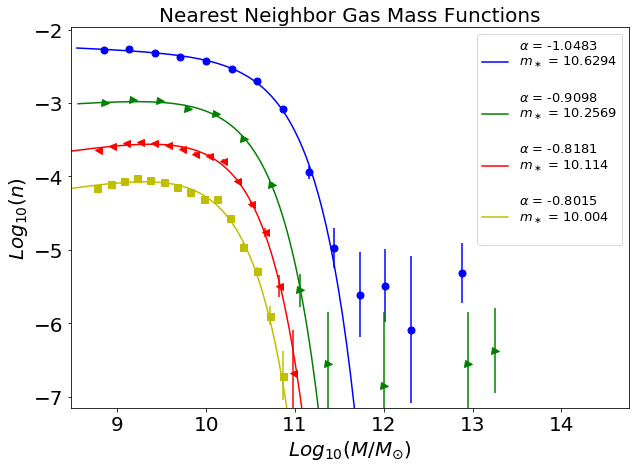

In [95]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,10**(8.7))
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,0)
#histo(15)
a = SchtrGraph2(15,"quartilesGas","Nearest Neighbor Gas Mass Functions",True)

In [96]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.00770807  0.00814783]
 [ 0.00759576  0.00734023]
 [ 0.00633408  0.00629733]
 [ 0.00707164  0.00712361]]


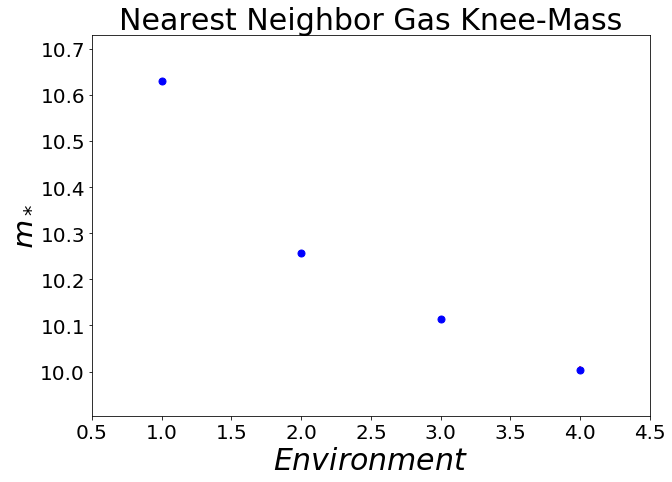

In [97]:
graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor Gas Knee-Mass","Quartiles_knee_mass_gas")

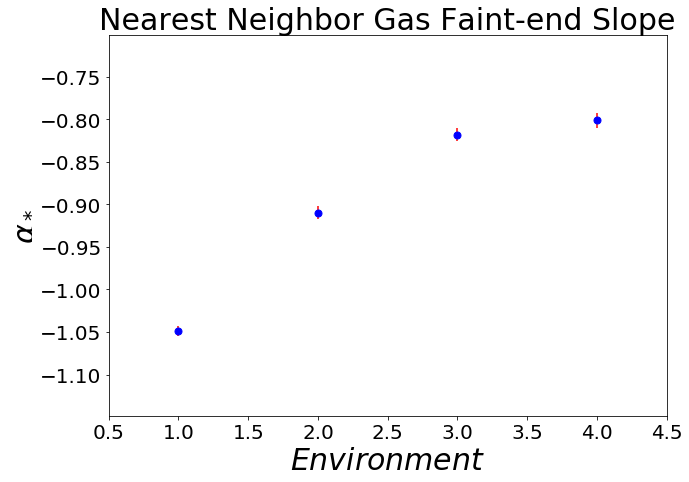

In [98]:
graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor Gas Faint-end Slope","quartiles_slope_gas")

# GAS TWEB

number of haloes before: 191443
number of haloes after: 144832
16982 72021 48900 6929 144832
......................................................
0.00122834858831 [  4.21555540e-05   3.98725670e-05]
-1.02018946797 [ 0.01119557  0.01110212]
10.4062851512 [ 0.01457902  0.01567471]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:171: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00319874373809 [  4.54949791e-05   4.49189687e-05]
-0.986246705185 [ 0.00508607  0.00516031]
10.3910910479 [ 0.0062522   0.00616081]
......................................................
0.00283091365788 [  4.14820913e-05   4.21110906e-05]
-0.86001232573 [ 0.0068441   0.00713605]
10.1568498171 [ 0.00661402  0.00650005]
......................................................
0.000466551080727 [  1.62609624e-05   1.68262635e-05]
-0.729815584508 [ 0.02229131  0.02290462]
9.88322065662 [ 0.01487367  0.01475182]


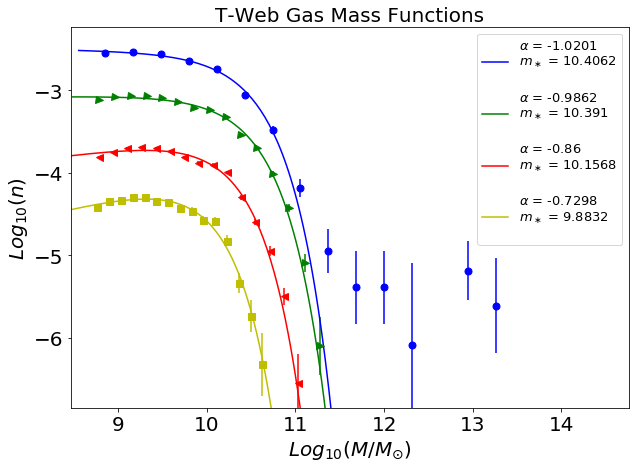

In [99]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,10**(8.7))
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,0)

a = SchtrGraph2(15,"T-Web_Gas","T-Web Gas Mass Functions",True)

In [100]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.01457902  0.01567471]
 [ 0.0062522   0.00616081]
 [ 0.00661402  0.00650005]
 [ 0.01487367  0.01475182]]


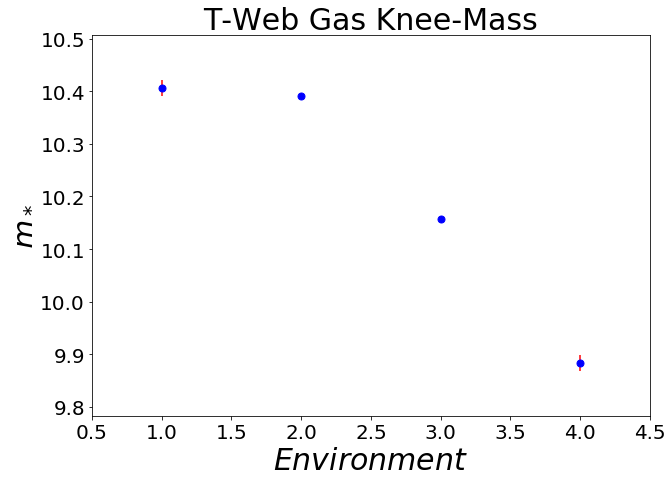

In [101]:
graph(ms,dms,0.1,r"$m_*$","T-Web Gas Knee-Mass","Tweb_knee_mass_Gas")

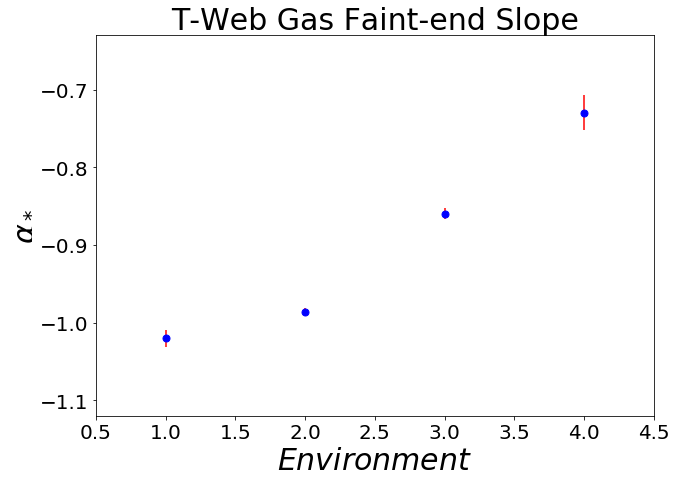

In [102]:
graph(alph,dalph,0.1,r"$\alpha_*$","T-Web Gas Faint-end Slope","TWeb_slope_gas")

# DM NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 115994
28999 28998 28999 28999 115995
......................................................
4.52495505475e-05 [  4.58699241e-06   4.14523280e-06]
-1.58402915514 [ 0.00542313  0.00526232]
13.3228495607 [ 0.05242065  0.05218849]
......................................................
0.000205072603335 [  1.98862987e-05   1.93528331e-05]
-1.71396518218 [ 0.00969886  0.01022683]
12.0066105838 [ 0.03697668  0.03568174]
......................................................
0.000319389877487 [  2.41697743e-05   2.31928946e-05]
-1.6823226013 [ 0.01253414  0.01274615]
11.5311559337 [ 0.02451601  0.02375064]
......................................................
0.000280690595542 [  2.50627282e-05   2.47279660e-05]
-1.8066889042 [ 0.01530468  0.01563188]
11.3596344919 [ 0.02617151  0.02522939]


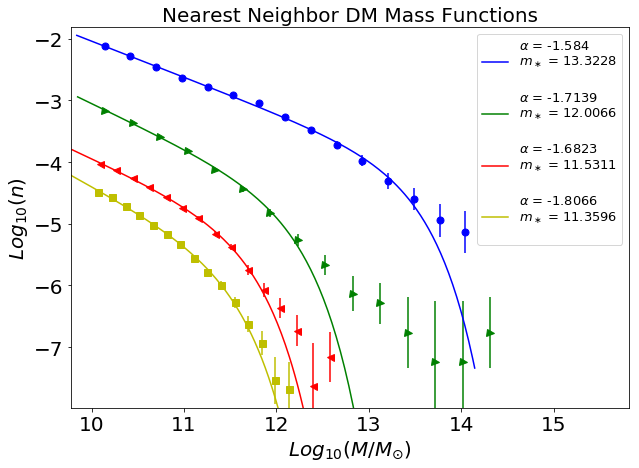

In [103]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,10**(10))
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,0)

#histo(15)
a = SchtrGraph2(15,"quartilesDM","Nearest Neighbor DM Mass Functions",True)

In [104]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.05242065  0.05218849]
 [ 0.03697668  0.03568174]
 [ 0.02451601  0.02375064]
 [ 0.02617151  0.02522939]]


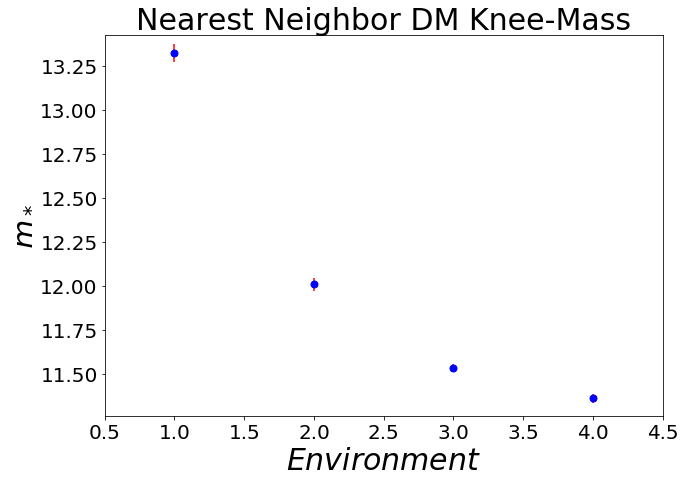

In [105]:
graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor DM Knee-Mass","Quartiles_knee_mass_DM")

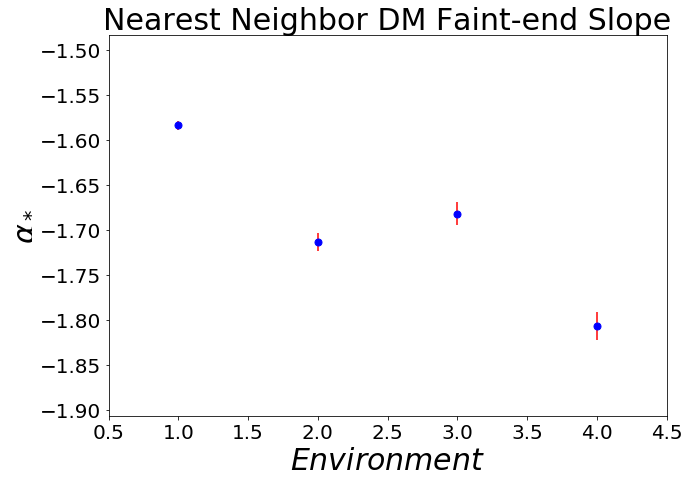

In [106]:
graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor DM Faint-end Slope","quartiles_slope_DM")

# DM TWEB ( Schechter functions are well adjusted to MF )

number of haloes before: 191443
number of haloes after: 115994
15867 56579 37920 5628 115994


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
3.69396197313e-09 [  2.43276703e-09   1.23886361e-07]
-1.720428635 [ 0.00534976  0.00518567]
18.1524956283 [ 0.19015794  0.29559341]
......................................................
7.65852145224e-05 [  5.64684825e-06   5.06242987e-06]
-1.75315831089 [ 0.00459042  0.00449645]
12.7098334778 [ 0.0292895   0.03041691]
......................................................
0.000206503412587 [  1.34131577e-05   1.32566631e-05]
-1.76037138383 [ 0.00917202  0.00926067]
11.7100911108 [ 0.02207531  0.02093682]
......................................................
0.000107522810638 [  1.93408294e-05   1.70941293e-05]
-1.6817821883 [ 0.04534663  0.04527558]
11.0109138336 [ 0.04770364  0.0454563 ]


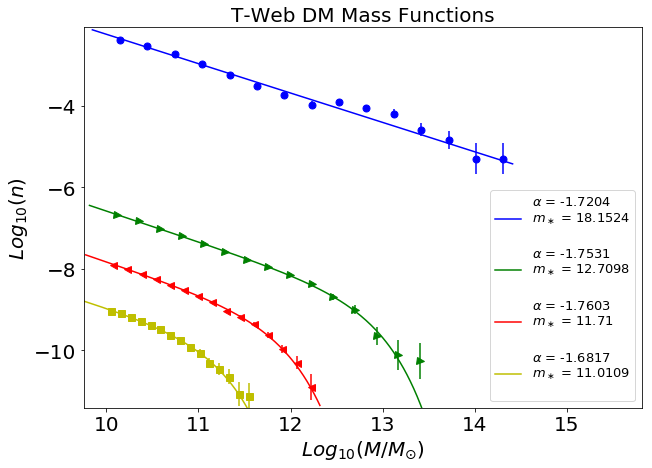

In [107]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,10**(10))
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,0)

a = SchtrGraph2(15,"T-Web_DM","T-Web DM Mass Functions",True)

In [108]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.19015794  0.29559341]
 [ 0.0292895   0.03041691]
 [ 0.02207531  0.02093682]
 [ 0.04770364  0.0454563 ]]


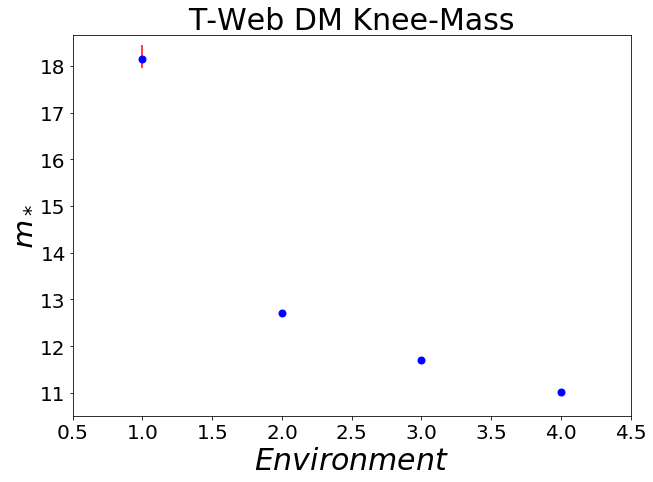

In [109]:
graph(ms,dms,0.5,r"$m_*$","T-Web DM Knee-Mass","Tweb_knee_mass_DM")

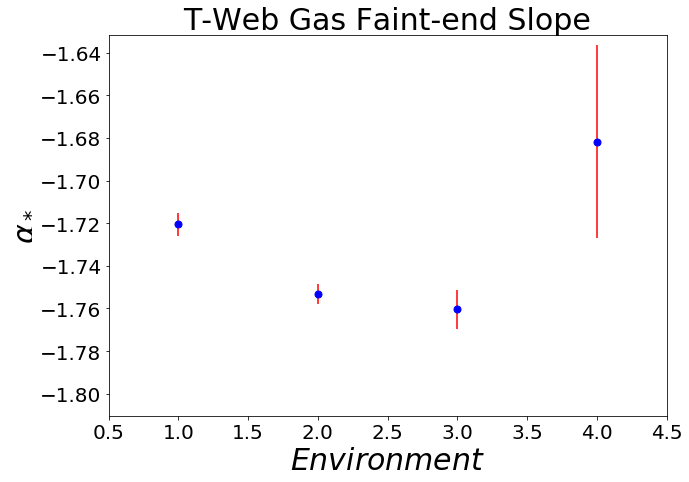

In [110]:
graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Gas Faint-end Slope","TWeb_slope_gas")

# NEAREST NEIGHBOR STELLAR MF

number of haloes before: 191443
number of haloes after: 99109
24778 24777 24777 24777 99109
......................................................
0.000350735749825 [  1.01324767e-05   9.89423899e-06]
-1.17197056386 [ 0.0035486   0.00349556]
11.2194194004 [ 0.02189208  0.02103268]
......................................................
0.000367023555494 [  1.49959708e-05   1.43541209e-05]
-1.23097277192 [ 0.00486975  0.00491935]
10.6733215229 [ 0.02692858  0.02711339]
......................................................
0.00040498265692 [  1.46614013e-05   1.47235694e-05]
-1.23270278601 [ 0.00563914  0.00568046]
10.2219131584 [ 0.02097504  0.02138566]
......................................................
0.000476822796106 [  1.77531275e-05   1.75604929e-05]
-1.24272788312 [ 0.00661944  0.00662282]
9.90005636002 [ 0.01967844  0.01882131]


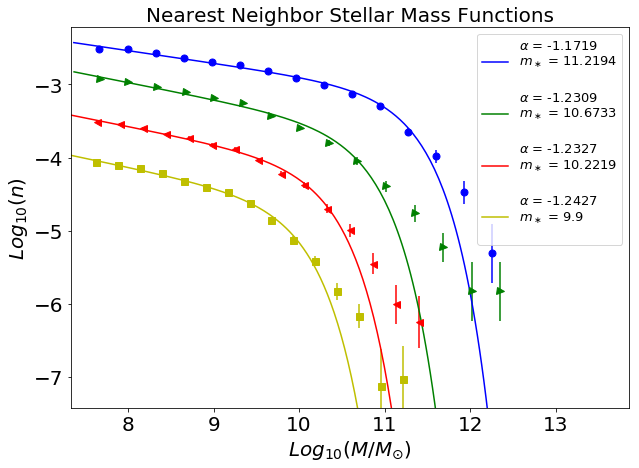

In [111]:
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,0)
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,10**(7.5))
#histo(15)
a = SchtrGraph2(15,"quartilesSellar","Nearest Neighbor Stellar Mass Functions",True)

In [112]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.02189208  0.02103268]
 [ 0.02692858  0.02711339]
 [ 0.02097504  0.02138566]
 [ 0.01967844  0.01882131]]


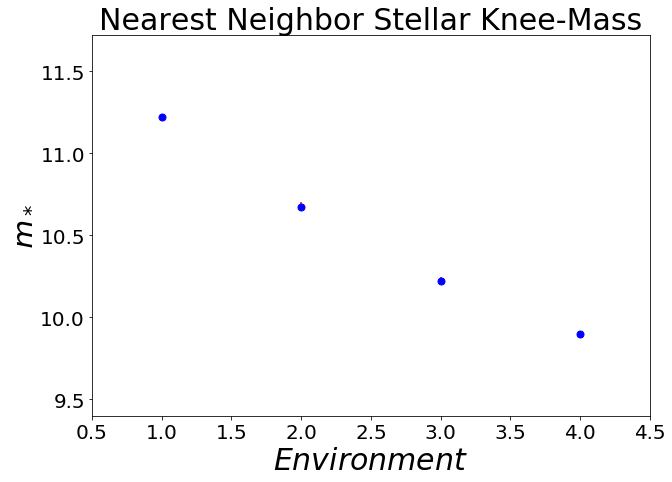

In [113]:
graph(ms,dms,0.5,r"$m_*$","Nearest Neighbor Stellar Knee-Mass","NN_knee_mass_Stellar")

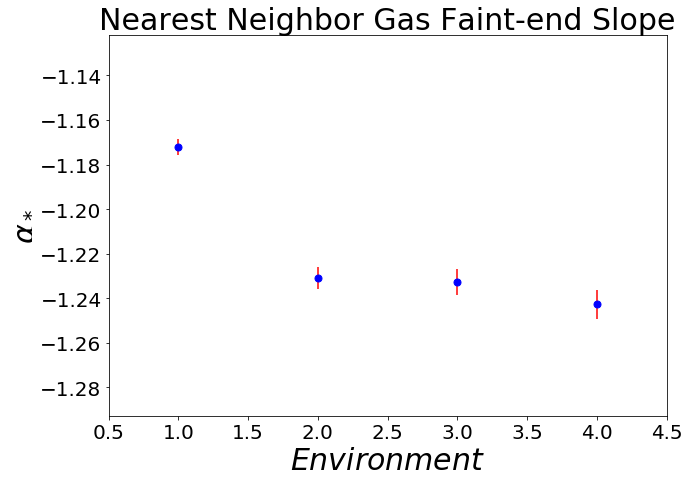

In [114]:
graph(alph,dalph,0.05,r"$\alpha_*$","Nearest Neighbor Gas Faint-end Slope","NN_slope_Stellar")

# TWEB STELLAR MF

number of haloes before: 191443
number of haloes after: 99109
17942 51362 26647 3158 99109
......................................................
0.000225751239851 [  1.42163506e-05   1.27447601e-05]
-1.1946533245 [ 0.00584656  0.0055116 ]
11.1947905333 [ 0.0512675   0.05442784]
......................................................
0.000490397425352 [  1.23895649e-05   1.30982498e-05]
-1.2664393536 [ 0.00279621  0.00290572]
10.874003546 [ 0.01812055  0.01761897]
......................................................
0.000395407047597 [  1.38194115e-05   1.35865635e-05]
-1.24185746649 [ 0.00542728  0.00540979]
10.1496041709 [ 0.01904798  0.01929266]
......................................................
6.61759237253e-05 [  6.60909549e-06   5.76751601e-06]
-1.20579393939 [ 0.02214232  0.02102517]
9.53172745094 [ 0.04126965  0.04287831]


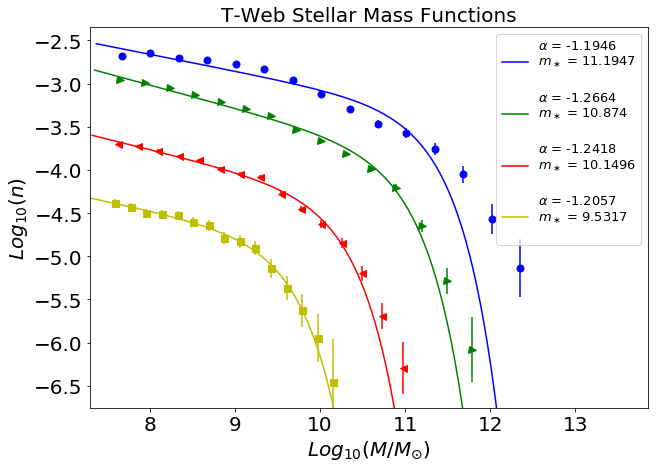

In [115]:
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(0))
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(7.5))

a = SchtrGraph2(15,"T-Web_Stellar","T-Web Stellar Mass Functions",True)

[[ 0.0512675   0.05442784]
 [ 0.01812055  0.01761897]
 [ 0.01904798  0.01929266]
 [ 0.04126965  0.04287831]]


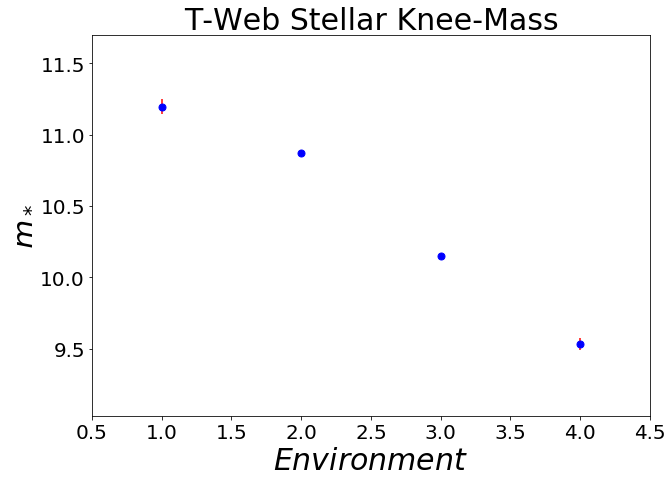

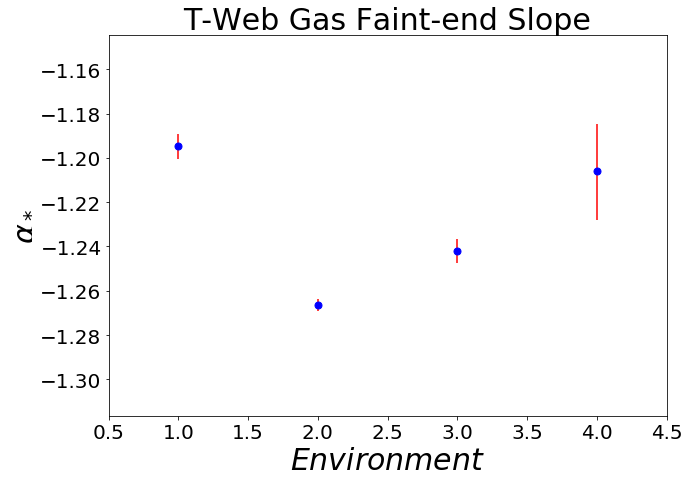

In [116]:
alph,dalph,ms,dms = a
print(dms.T)
graph(ms,dms,0.5,r"$m_*$","T-Web Stellar Knee-Mass","Tweb_knee_mass_Stellar")
graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Gas Faint-end Slope","Tweb_slope_Stellar")

# NEAREST NEIGHBOR BH MF

number of haloes before: 191443
number of haloes after: 5106
1277 1276 1277 1277 5107
......................................................
6.20404717053e-06 [  2.15532321e-06   1.60303292e-06]
-1.46689375201 [ 0.02897919  0.02690149]
9.47814654784 [ 0.16667613  0.16258203]
......................................................
6.08679973951e-06 [  1.43100145e-06   1.32527617e-06]
-1.40785848903 [ 0.02345874  0.0244736 ]
9.78439746278 [ 0.13326168  0.11782428]
......................................................
3.54744527114e-06 [  1.51060477e-06   1.29389726e-06]
-1.54092554354 [ 0.03099536  0.02971153]
9.66523250389 [ 0.24299749  0.17937056]


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
2.22955815041e-07 [  3.25853262e-07   1.47350909e-07]
-1.88740756937 [ 0.02611185  0.02580972]
10.1705756342 [ 0.47363116  0.4144419 ]


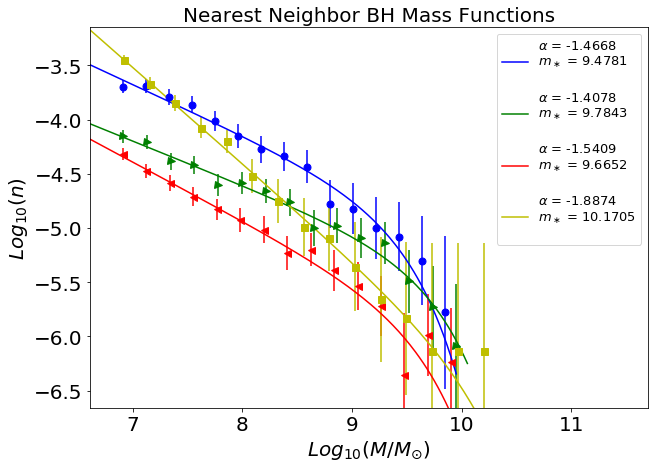

In [117]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,3,10**6.8)
#6.4
#histo(15)
a = SchtrGraph2(15,"quartilesBH","Nearest Neighbor BH Mass Functions",True)

[[ 0.16667613  0.16258203]
 [ 0.13326168  0.11782428]
 [ 0.24299749  0.17937056]
 [ 0.47363116  0.4144419 ]]


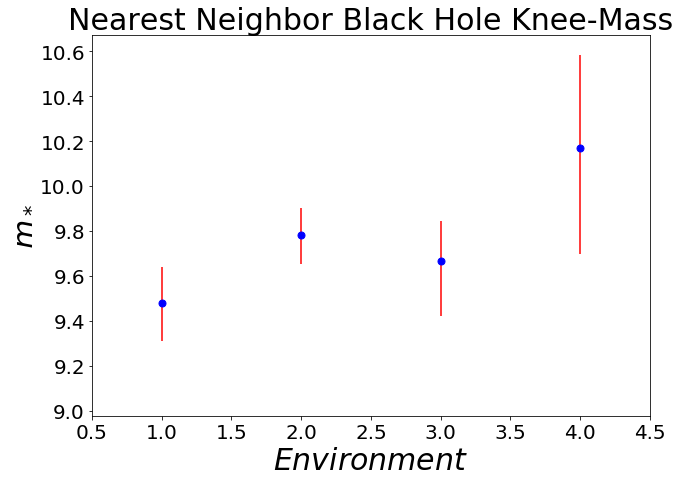

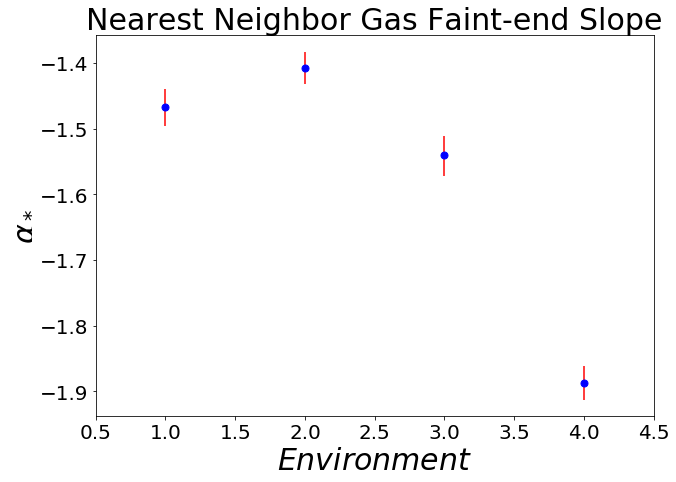

In [118]:
alph,dalph,ms,dms = a
print(dms.T)
graph(ms,dms,0.5,r"$m_*$","Nearest Neighbor Black Hole Knee-Mass","NN_knee_mass_BH")
graph(alph,dalph,0.05,r"$\alpha_*$","Nearest Neighbor Gas Faint-end Slope","NN_slope_BH")

# TWEB BH MF

number of haloes before: 191443
number of haloes after: 5106
1828 2838 435 5 5106
......................................................
1.60616912757e-05 [  2.11100174e-06   1.85810295e-06]
-1.30644267183 [ 0.01818461  0.01809812]
9.73217540574 [ 0.05789686  0.06324523]
......................................................
1.73623759569e-05 [  3.39629467e-06   2.95971091e-06]
-1.57088524375 [ 0.02490024  0.02443653]
8.91172317209 [ 0.07518026  0.07451837]


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
4.89648668054e-06 [  1.04777524e-07   1.38351528e-07]
-1.93489614487 [  8.49042609e-05   8.36799624e-05]
7.78550332942 [ 0.00082791  0.00100845]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in power


......................................................
-2.48162576394e-08 [  5.93491073e-08   6.98899904e-08]
-1.00883399795 [  1.01913146e-04   9.07783237e-05]
308.215328113 [ 0.0007772   0.00074871]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:163: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:187: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:188: RuntimeWarning: invalid value encountered in log10


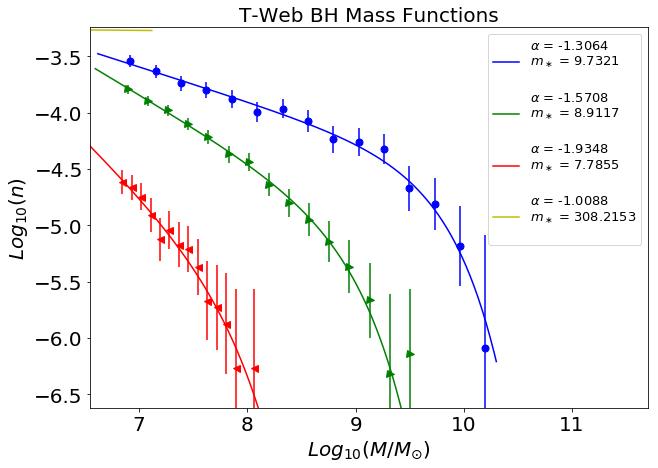

In [119]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,3,10**6.8)
a = SchtrGraph2(15,"T-Web_BH","T-Web BH Mass Functions",True)